In [2]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x5cae2000 @  0x7f5d36f231c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms


import matplotlib.pyplot as plt
import numpy as np


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn import metrics
import seaborn as sns
from IPython.display import set_matplotlib_formats

from pylab import rcParams


set_matplotlib_formats('retina')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 8

In [49]:
torch.cuda.device_count()

1

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

In [51]:
batch_size = 32


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

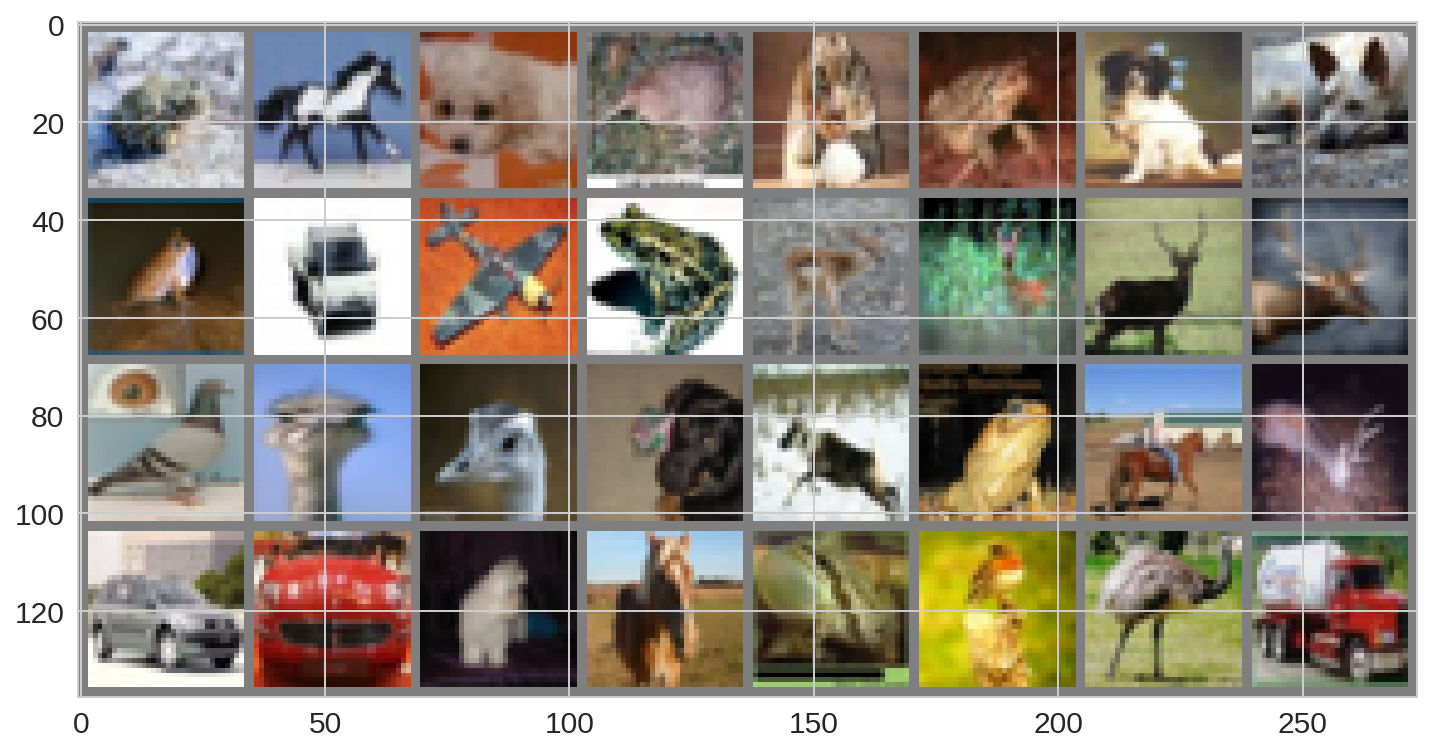

In [53]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [54]:
print(' '.join('%s' % classes[labels[j]] for j in range(4)))

frog horse dog bird


In [0]:
class Model(nn.Module):
    def __init__(self, num_classes=10):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.FractionalMaxPool2d(kernel_size=2, output_ratio=0.8),
            nn.Dropout(p=0.4),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.FractionalMaxPool2d(kernel_size=2, output_ratio=0.8),
            nn.Dropout(p=0.5),
            
            nn.Conv2d(128, 32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.FractionalMaxPool2d(kernel_size=2, output_ratio=0.8),
            nn.Dropout(p=0.3),
            
            nn.Conv2d(32, 8, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.FractionalMaxPool2d(kernel_size=2, output_ratio=0.8),
            nn.Dropout(p=0.2)
        )
        self.classifier = nn.Linear(1152, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [0]:
model = Model().to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [58]:
train_loss = []
test_loss = []

EPOCHS_TO_TRAIN = 100


for epoch in range(EPOCHS_TO_TRAIN):
    model.train()
    e_train_loss = []
    for data, target in train_loader:
        
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()

        y_pred = model(data)

        loss = criterion(y_pred, target)
        e_train_loss.append(loss.item())
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
    mean_train_loss = np.mean(e_train_loss)
    train_loss.append(mean_train_loss)
        
    model.eval()
    e_test_loss = []
    correct = 0
    with torch.no_grad():
      for data, target in test_loader:

          data, target = data.to(device), target.to(device)
          output = model(data)

          loss = criterion(output, target).item()
          e_test_loss.append(loss)

          # get the index of the max
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    mean_test_loss = np.mean(e_test_loss)
    test_loss.append(mean_test_loss)
    
    print(f"""
    ######### Epoch {epoch + 1} #########\n
    average train loss: {mean_train_loss}
    average test loss: {mean_test_loss}
    test accuracy: {correct}/{len(test_loader.dataset)} {100. * correct / len(test_loader.dataset)}%
""")


    ######### Epoch 1 #########

    average train loss: 1.755097424839066
    average test loss: 1.8160482843082173
    test accuracy: 3395/10000 33%


    ######### Epoch 2 #########

    average train loss: 1.4121532537810557
    average test loss: 1.6549211249183924
    test accuracy: 3966/10000 39%


    ######### Epoch 3 #########

    average train loss: 1.3130906745553093
    average test loss: 1.563010899784466
    test accuracy: 4252/10000 42%


    ######### Epoch 4 #########

    average train loss: 1.2442858187876218
    average test loss: 1.7231758871017553
    test accuracy: 3753/10000 37%


    ######### Epoch 5 #########

    average train loss: 1.1879479528541224
    average test loss: 1.7271721728693563
    test accuracy: 3902/10000 39%


    ######### Epoch 6 #########

    average train loss: 1.1394510145608385
    average test loss: 1.3780691566558692
    test accuracy: 5017/10000 50%


    ######### Epoch 7 #########

    average train loss: 1.0916589739531641
 


    ######### Epoch 36 #########

    average train loss: 0.7677100698153178
    average test loss: 0.8567671661559766
    test accuracy: 6983/10000 69%


    ######### Epoch 37 #########

    average train loss: 0.7659243946645936
    average test loss: 0.8695555003687215
    test accuracy: 6919/10000 69%


    ######### Epoch 38 #########

    average train loss: 0.7574150194476524
    average test loss: 0.8524796024869425
    test accuracy: 6955/10000 69%


    ######### Epoch 39 #########

    average train loss: 0.753682038338613
    average test loss: 0.8582459813870561
    test accuracy: 6974/10000 69%


    ######### Epoch 40 #########

    average train loss: 0.7511046358353803
    average test loss: 0.872151014046928
    test accuracy: 6939/10000 69%


    ######### Epoch 41 #########

    average train loss: 0.7464715253635621
    average test loss: 0.8249442462151805
    test accuracy: 7088/10000 70%


    ######### Epoch 42 #########

    average train loss: 0.74590006464


    ######### Epoch 71 #########

    average train loss: 0.6761390384064984
    average test loss: 0.7692298121726551
    test accuracy: 7299/10000 72%


    ######### Epoch 72 #########

    average train loss: 0.6746079721133524
    average test loss: 0.7588491571216157
    test accuracy: 7395/10000 73%


    ######### Epoch 73 #########

    average train loss: 0.6700027250587673
    average test loss: 0.7605776882019287
    test accuracy: 7344/10000 73%


    ######### Epoch 74 #########

    average train loss: 0.6686973265555144
    average test loss: 0.7436704641333023
    test accuracy: 7386/10000 73%


    ######### Epoch 75 #########

    average train loss: 0.66815158658049
    average test loss: 0.7070284179224374
    test accuracy: 7549/10000 75%


    ######### Epoch 76 #########

    average train loss: 0.6673646914276341
    average test loss: 0.74133771419906
    test accuracy: 7410/10000 74%


    ######### Epoch 77 #########

    average train loss: 0.6652695847411

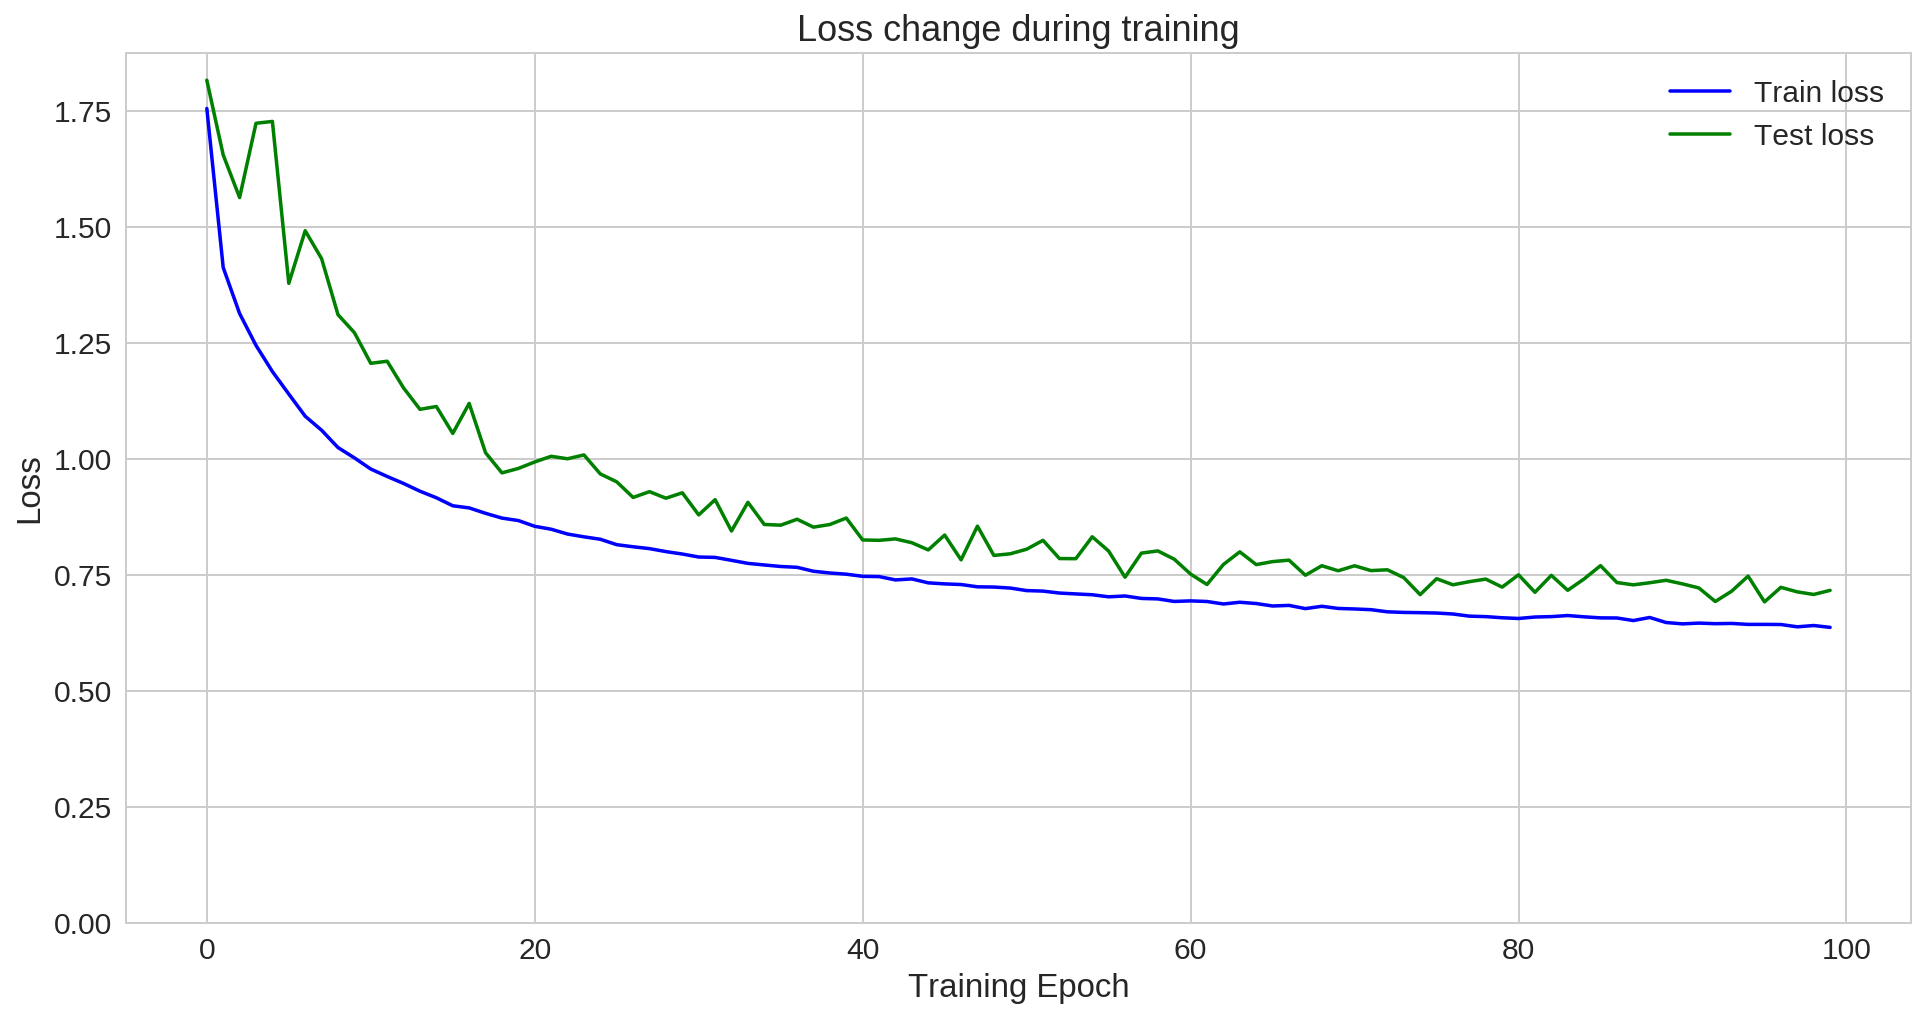

In [59]:
plt.figure(figsize=(16, 8))

plt.plot(train_loss, "b", label="Train loss")

plt.plot(test_loss, "g", label="Test loss")

plt.title("Loss change during training")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [0]:
model.eval()

ys = []
y_hats = []

with torch.no_grad():
  for data, target in test_loader:
    
      data = data.to(device)
      output = model(data)

      pred = output.data.max(1, keepdim=True)[1]

      pred = pred.cpu().numpy().flatten()   

      y_hats.extend(pred)
      ys.extend(target)

In [0]:
ys = [classes[y.item()] for y in ys]
y_hats = [classes[y.item()] for y in y_hats]

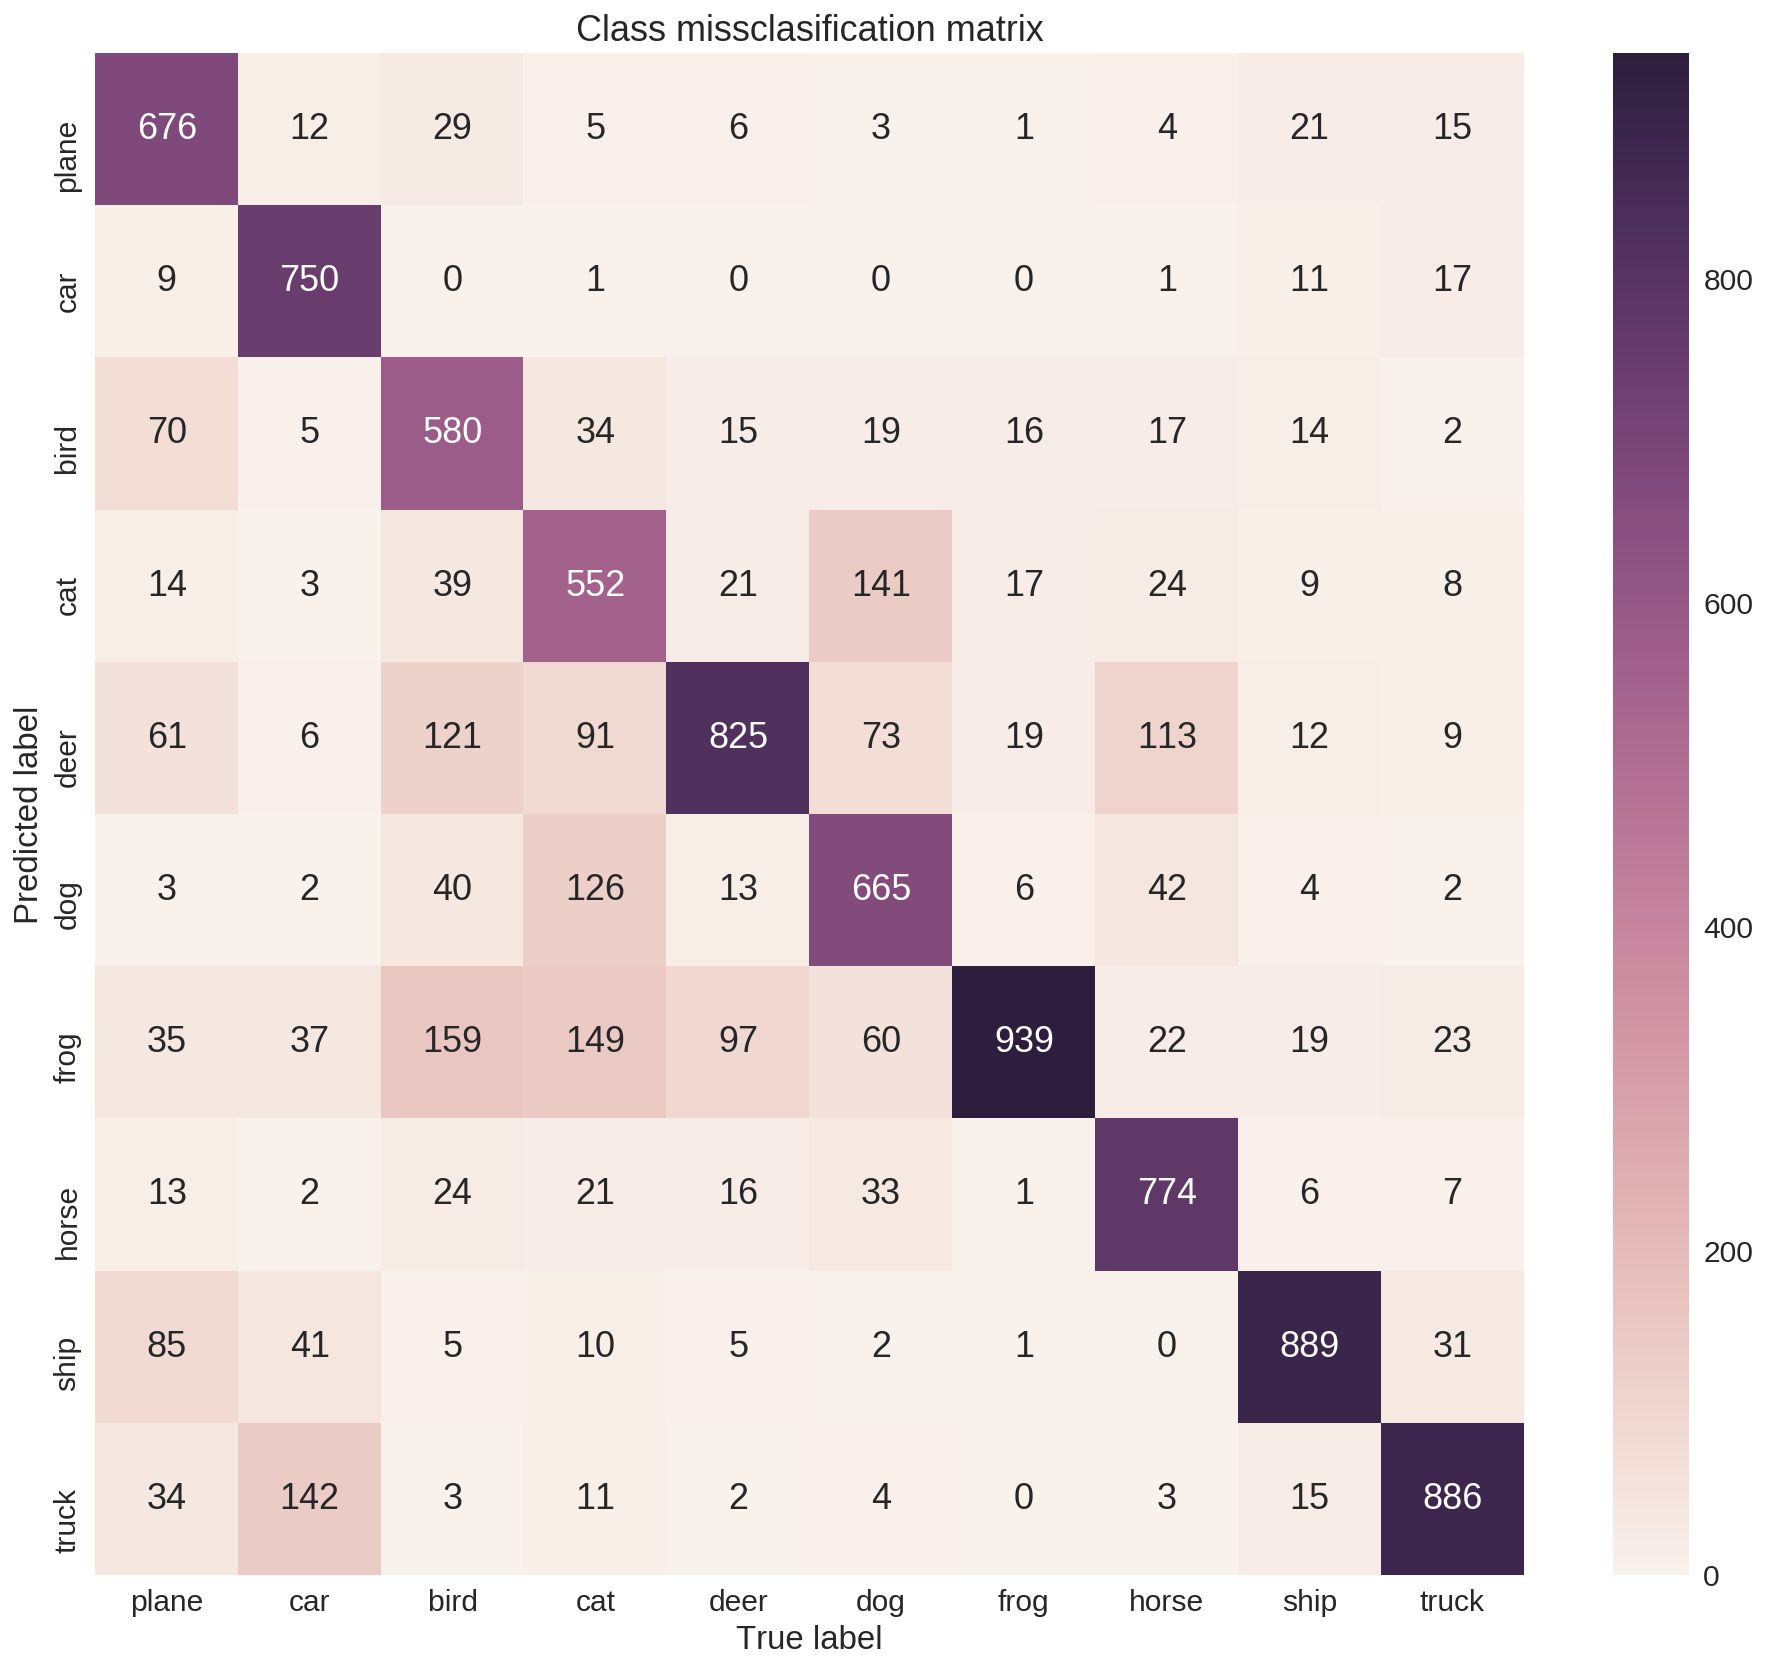

In [87]:
confusion_matrix = metrics.confusion_matrix(y_hats, ys , classes)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.title("Class missclasification matrix")
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()